## Setup

Import stuff we'll be needing, and load the data file into a pandas DataFrame. You'll have to download the data manually from https://data.bl.uk/ethos/EThOSCSV201803.zip, since the British Library website prevents automated downloads.

In [51]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import operator as opr
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import display, HTML

In [11]:
datafile = "EThOSCSV_201803.csv"
if not os.path.isfile(datafile):
    msg = "Please download the data file from https://data.bl.uk/ethos/EThOSCSV201803.zip and unzip it in the working directory."
    print(msg)
else:
    dfall = pd.read_csv(datafile)

The data includes all kinds of theses, but 94% are PhD theses, so we focus our analysis on them, to get a more consistent data set.

In [12]:
def isphd(elem):
    """ Return true if elem["Qualification"] is a PhD of some sort. """
    q = elem["Qualification"]
    if type(q) == str:
        qred = q.strip().lower()
        if ("ph.d" in qred or "dphil" in qred or "phd" in qred):
            return True
    return False

dfisphd = dfall.apply(isphd, axis=1)
phdratio = dfisphd.sum()/len(dfall)
print("Ratio of PhD theses to all theses: {}".format(phdratio))

df = dfall[dfisphd]

Ratio of PhD theses to all theses: 0.9425082508250825


Even though the data is from 2018, the number of theses in the database drops sharply after 2015. This is presumably due to the database not being quite up to date. At the early end, there's only a handful of theses per year before 1925 or so, at which point the number shoots up fast. We thus restrict the data to the time window of 1925-2015, to get good and reliable statistics.

In [13]:
counts_by_year = df.Date.value_counts().sort_index()

Text(0.5, 0, 'Year')

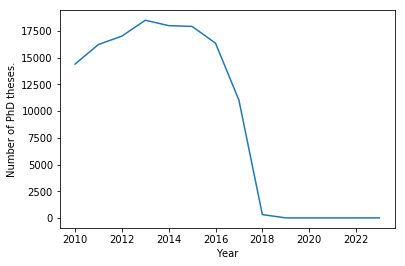

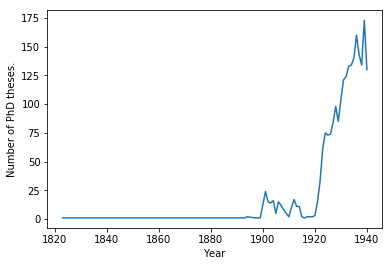

In [14]:
# Plots of the number of theses at the early and late ends of the time period, to illustrate the reason to restrict the window.
plt.figure()
counts_by_year[2010:].plot()
plt.ylabel("Number of PhD theses.")
plt.xlabel("Year")

plt.figure()
counts_by_year[:1940].plot()
plt.ylabel("Number of PhD theses.")
plt.xlabel("Year")

In [15]:
late_cutoff = 2015
early_cutoff = 1925
counts_by_year = counts_by_year[early_cutoff:late_cutoff]
df = df[(early_cutoff <= df.Date) & (df.Date <= late_cutoff)]

## Number of theses per year and institution

First, a basic look at the number of PhD theses accepted in the UK over our chosen time period. Note the logarithmic vertical axis. The two word summary here would clearly be "exponential growth". In 1925 a bit less than a hundred PhDs were awarded, and now we are approaching 20 000 per year. The most notable features are the huge dip during WW2 in the middle of the otherwise steady exponential period from 1925 to 1960 (in the above early-times plot you can also see a dip during WW1, although the signal there is more noisy), then even faster exponential growth in the 1960-1980 window, and finally a more moderate steady pace again from 1980 onwards. Note that when I talk about rate of growth here I'm talking in multiplicative terms, meaning that for instance since 1980 the number of new PhDs has been growing by a roughly constant _percentage_ per year, not a constant number. Note also the bump a few years after WW2, presumably from people who postponed the start of their studies until after the war and are graduating all at once.

Text(0.5, 0, 'Year')

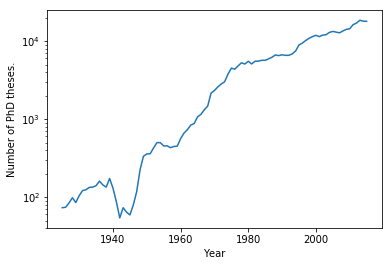

In [16]:
plt.figure()
plt.semilogy(counts_by_year)
plt.ylabel("Number of PhD theses.")
plt.xlabel("Year")

Next we look at the contributions of different institutions to the total output of PhDs. The below plot shows the total thesis count per year divided between different universities. This shows the drastic change in the structure of higher education between roughly 1960 and 1980, that also produced the fastest growth period in the above plot: There's an explosion in the number of PhDs coming from small universities, many of which are founded during this period or right before. Until around 1960 Oxford, Cambridge and Edinburgh produced around 80% of PhDs in the country, by 1980 it was closer to 20%, and has stayed roughly constant since. They remain the largest PhD factories, together with Manchester and Imperial College London, but the field has been field with dozens of smaller institutions.

There are also some interesting individual stories in this same plot. Oxford used to dominate its rival Cambridge with a doctoral output several times larger until around 1970, after which the two have been roughly equal. Imperial has an interesting bulge of activity during the 1960s surrounded by more quiet times on both sides. University College London grew fast during the late 90s and is now the 7th biggest in the country. Overall, this millenium there's been again a slight squeeze, where the big institutions have been growing and the smaller ones have been shrinking, although these changes are very minor compared to the opposite explosion in the 60s and 70s.

[TODO Check some history: Are the UCL and ICL changes possibly due to organizational restructuring? Can we connect the recent squeeze to changes in something like funding policies?]

In [17]:
counts_by_yearandinst = df.groupby(["Institution", "Date"]).size().unstack("Institution").fillna(0.0)
# We sort institutions based on PhD output in the last year of our time window.
counts_by_yearandinst = counts_by_yearandinst.sort_values(late_cutoff, axis="columns", ascending=False)
instratios_by_year = counts_by_yearandinst.divide(counts_by_year, axis="index")

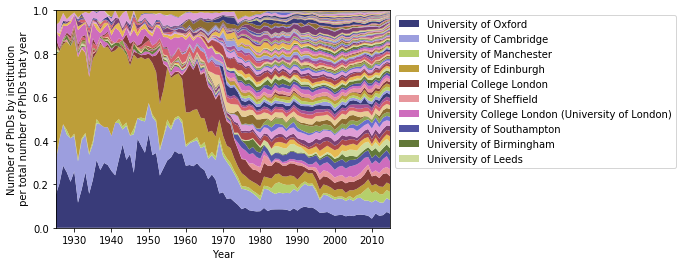

In [79]:
# We can't show the full legend with dozens of entries, so we restrict to a few of the
# most important ones.
num_legendentries = 10

# We use one of matplotlibs color maps with 20 colors since we have a lot areas to plot,
# but to not have similar colors right next to each other we mix up the order.
colors = cm.tab20b.colors
num_colors = len(colors)
colors = [colors[i*3 % num_colors] for i in range(num_colors)]

lines = plt.stackplot(instratios_by_year.index, instratios_by_year.values.T, colors=colors)
plt.ylabel("Number of PhDs by institution\n per total number of PhDs that year")
plt.xlabel("Year")
plt.ylim(0.0, 1.0)
plt.xlim(early_cutoff, late_cutoff)
plt.legend(lines[:num_legendentries], instratios_by_year.columns[:num_legendentries], loc="upper left", bbox_to_anchor=(1.0, 1.0));

Just to underline the fact that the drop in the proportion of the largest instutions compared to the country total is not at all due to the output of the dominant institutions declining, here are the absolute numbers of PhDs produced by the current 8 largest producers.

In [ ]:
counts_by_yearandinst.iloc(1)[:8].plot()
plt.ylabel("Number of PhDs produced")
plt.xlabel("Year")

## Digging into the titles

So far we've only looked at where and when PhD theses have been written. The dataset doesn't hold that much more information to toy with. It doesn't list departments or faculties, keywords or research fields, nor do I have access to full texts of the theses. But what it does have is the titles of these theses. Let's see what we can learn from them.

Now thesis titles aren't exactly prose. They typically aren't full sentences and their grammatical forms vary wildly, which makes analysis of their structure tricky and, I would guess, in many cases a bit futile. Unlike with more structured text, almost as much information as in the title itself is contained in just a list of words appearing in the title. Lists of words are also much easier to analyse, so we'll go with that.

To start, we strip the titles of any punctation and so called stop words like articles and prepositions that don't tell us much, and make everything lower case. Next, there's a few choices to be made: We could do what's called "stemming", and collapse for instance "study", "studies", "studied" and "studying" all into a single word. Due to the nature of academic titles inflections like "studied" and "studying" don't appear too often, and the main affect of this would be getting rid of the plural/singular distinctions. I choose not to do this, perhaps partly out of laziness, but more so because as we'll see below, plurals and singulars of the same word sometimes appear in significantly different kinds of titles. Moreover, with academic vocabulary, doing this properly isn't straight-forward: the stemming algorithm should for instance know to combine "phenomenon" and "phenomena", but probably not "phenomenal" or "phenomenology".

[TODO Check what stemmers are available and they are capabable of. If it's easy, I should at least see if it would make a difference. Someone mentioned KStemmer.]

Another choice I make is to remove hyphens as unnecessary punctuation. Here you lose some and you win some. "Post-modern" should certainly be grouped together with "postmodern", but "biodiversity-ecosystem" (which appears in 5 titles) would be better split into two words.

In [ ]:
def splitstr(s):
    """ For a string, remove most punctuation, lower case, and split into words. Return the words.
    """
    puncts = '!"&\'(),./:;<=>?[\\]`{|}-'
    return s.lower().translate(str.maketrans('', '', puncts)).split()

def filter_stopwords(l):
    """ Take a list of strings, filter out prepositions, articles, and other boring words. """
    verbotens = ["the", "a", "in", "on", "of", "at", "as", "so", "and", "or", "for", "to", "with", "an", "by", "it", "from", "its", "their", "them", "into", "onto"]
    return tuple(s for s in l if s not in verbotens)

In [ ]:
df["Words"] = df["Title"].apply(splitstr).apply(filter_stopwords)

A handy thing to have: A function that, given a word, spits out example titles where it appears.

In [ ]:
def get_example_titles(word, n=1):
    titles_with_word = df[df["Words"].apply(lambda x: word in x)]["Title"]
    n = min(n, len(titles_with_word))
    examples = tuple(titles_with_word.sample(n).values)
    return examples

To get the title-analysis going, we want three different objects:
* A DataFrame that lists the total number of titles in which each word appears.
* The same thing but now per year. (We could do per institution as well, but let's leave that for later.)
* A so called co-occurence graph, i.e. a weighted graph where nodes are words and edges tell us which words appear in the same titles and how often.

In [ ]:
wordcounts_by_year = df.groupby("Date")["Words"].apply(
    lambda x: pd.Series(np.concatenate(x.tolist())).value_counts()
).unstack("Date").fillna(0.0).T

In [ ]:
total_wordcounts = wordcounts_by_year.sum(axis=0)
# Sort both total_wordcounts and wordcounts_by_year to have the most common words first.
order = (-total_wordcounts).argsort()
total_wordcounts = total_wordcounts[order]
wordcounts_by_year = wordcounts_by_year.reindex(total_wordcounts.index, axis=1)

In [ ]:
wordrates_by_year = wordcounts_by_year.divide(counts_by_year, axis=0)  # TODO Do I actually use this one?

Now making the co-occurence graph requires some thought. First off, we've got around 190,000 distinct words in about 430,000 titles (academics like their jargon). That's a lot of nodes for a graph. However, only 10,000 or so, a much more manageable number, appear in more than 30 thesis titles. Thus for both the sake of keeping the DataFrame reasonably light and for a having useful number of data points for each word, we restrict the graph to the 10,000 most common words.

Note also that when making word co-occurence graphs of texts, co-occurences are often given more weight if the words are next to each rather than just in the same sentence. We don't make this distinction since the titles are pretty short anyway, and word orders in titles can get odd, making proximity less relevant.

In [ ]:
print("Number of unique words: {}. Number of theses: {}. Number of words with more than {} occurences: {}.".format(
    len(total_wordcounts), len(df), 30, len(total_wordcounts[total_wordcounts > 30])
))

For fun, here's some example words that are right at the brink of whether they are common enough to include in our graph or not.

In [ ]:
mainwords_number = 10000
print(total_wordcounts[mainwords_number-5:mainwords_number+5])

If you are running this notebook yourself, you can safely go make a cup of tea at this point. Building the graph takes about 10 minutes on my laptop. (We build it as an adjacency matrix.)

In [ ]:
# TODO Can I optimize this? Do it with a matrix product?
# The `samples` parameter could be used to take only a subset of the theses
# into account when building the graph. Handy for development and testing.
samples = np.inf
counter = 0
mainwords = total_wordcounts.index[:mainwords_number]
cooccurence = pd.DataFrame(0.0, index=mainwords, columns=mainwords)
for words in df["Words"]:
    words = tuple(filter(lambda w: w in mainwords, words))
    cooccurence.loc[words, words] += 1.0
    counter += 1
    if counter > samples:
        break

As we have it now, the edge weights of the graph just count the number of theses in which both words appear. This isn't quite what we want, since it's just dominate by commonly occuring words. There's several different ways we could normalize the weights. Dividing by the total appearance counts of the words (diagonal of the adjacency matrix) would make the weight of the edge between nodes A and B represent a conditional probability (or rather a frequency) P(A|B) of word A appearing in a title given that word B appears. We could also make a bidirectional graph that has both P(A|B) and P(B|A) stored for each edge. Or we could do a number of more symmetric normalizations that don't have as concrete an interpretation. A choice that we've found works well for what we want to do with this graph later is normalizing the edge between A and B by average of the frequencies of A and B. This is symmetric (the graph is undirected) and roughly speaking gives a large weight for edges that connect two words that appear roughly equally frequently and often together.

In [ ]:
D = np.diag(cooccurence.values)
ones = np.ones(D.shape)
DD = np.outer(D, ones) + np.outer(ones, D)
cooccurence = 2*cooccurence.divide(DD)

We use the NetworkX python package for handling the graph.

In [ ]:
adjmat = np.array(cooccurence.values)  # Makes a copy, to avoid modifying the original.
np.fill_diagonal(adjmat, 0.0)
g = nx.from_numpy_matrix(adjmat)
labels = {i: cooccurence.index[i] for i in range(len(cooccurence.index))}
g = nx.relabel_nodes(g, labels)

Another handy function to have: One that, given a word, gets related words from the co-occurence graph.

In [ ]:
def get_related_words(w, n=5):
    """ For a given word w, get the n (by default n=5) words with heaviest edges connected to w in the co-occurence graph.
    Returns a list of tuples (neighbor word, weight), sorted by weight.
    """
    node = g[w]
    neighborlist = ((k, v["weight"]) for k, v in node.items())
    return sorted(neighborlist, key=opr.itemgetter(1), reverse=True)[:n]

Finally, lets wrap in a function something we'll be doing repeatedly: Plot the popularity of a word over time and print out some often co-occuring words and example titles.

In [ ]:
def output_word_summary(w, n_related=5, n_examples=5):
    print("Word: {}".format(w))
    print("Related words: {}".format(get_related_words(w, n=n_related)))
    print("Example titles: {}".format(get_example_titles(w, n=n_examples)))
    fig = plt.figure()
    wordcounts_by_year[w].plot()
    plt.title(w)
    plt.ylabel("Number of theses with this word in the title")
    plt.xlabel("Year")

With all that set-up out of the way, let's dig into the data. First off, what are the most commonly occuring words in thesis titles, and how does their popularity vary over time?

In [ ]:
num_topwords = 10
for w in total_wordcounts.index[:num_topwords]:
    output_word_summary(w)

Nothing too exciting here: Generic terms that appear in all kinds of titles, with popularity rises reflecting the general rise in number of theses. The notable outliers are "studies" and "some", both of which sound a little vague and weasel-wordy to modern ears, and both of which peaked in popularity in the late 70s and have since fallen in popularity.

To get to more interesting trends, we can ask for words whose popularity has varied the most over time. To avoid this being dominated by terms with small but sharp peaks, we require the word to have appeared in the title of at least a 100 theses.

In [ ]:
num_topwords = 10
M = wordcounts_by_year.loc[:, total_wordcounts > 100]
stds = (M.std()/M.mean()).sort_values(ascending=False)
topwords = stds.index[:num_topwords]
for w in topwords:
    output_word_summary(w)

Unsurprisingly, given the exponential rise in the number of theses overall, this is dominated by words that simply didn't exist, at least not in academic parlance, until lately. "Elearning", "graphene", and some of the others are pretty straight-forward cases; from the related words and example titles we can see that the popularity of "mitigation" and "resilience" is clearly in the context of environmentalism, and similarly "scaffolds" should be seen in the context of bioengineering.

While this is getting interesting, and one could browse the above list further to find trends in particular fields (apparently microfluidic devices, whatever they are, have been a hot thing this past decade), I personally would find more interesting to see past booms: Now-forgotten once-hot academic trends. To highlight those, lets again look at terms with high variance, but this time also require that no ore than a third of the their title-appearances are from this millenium.

In [ ]:
num_topwords = 15
M = wordcounts_by_year.loc[:, (total_wordcounts > 100) & (total_wordcounts > 3.0*wordcounts_by_year.loc[2000:late_cutoff, :].sum())]
stds = (M.std()/M.mean()).sort_values(ascending=False)
topwords = stds.index[:num_topwords]
for w in topwords:
    output_word_summary(w)

Well now, this is getting fun.

Apparently particle physicists used the term GeV/c (gigaelectronvolts per speed of light), a unit for momentum, a lot from the early 60s to early 80s, when new particles were constantly being discovered and this was a typical momentum scale for the experiments at the time. (Nowadays they would be talking in TeV/c, tera instead of giga, but this term doesn't seem to be in common use since it doesn't occur in our dataset.) There seems to have been a flurry of research into Brassica Napus, aka oilseed rape, the plant, from roughly mid 80s to late 2000s. The peak coincides with what apparently was a breakthrough of some sort in GMO technology, and overall Brassica Napus has seen a huge increase in popularity as cultivar since 1975 (https://en.wikipedia.org/wiki/Rapeseed#History_of_the_cultivars). Other trends I lack the background to understand. Monoclonal antibodies have a huge peak around 1990, but a quick browse of wikipedia and google only tells me that they really became a thing in 1975 (and lead to a 1984 Nobel Prize) and are now a massive industry, but what exactly happened around 1990, I don't know. "Superconductors" is an especially interesting one for its multimodal structure. There's first a peak in the 60s and early 70s, a bit after the BCS theory of superconductivity was invented (1957) and the discovery of superconductors that could generate large magnetic fields, which has significant engineering applications. Starting from the late 80s is a second peak when high-temperature superconductors, that defy the BCS theory (or any theory, to this day), were discovered and then frantically studied.

Individual words like those above provide an almost endless list of rabbit holes that lead to stories of individual scientific discoveries and trends, but larger academic trends can not be captured by the popularities of single key words. However, one would naturally expect the co-occurences of words in titles to follow patterns, where words related to fields and subfields cluster together. The problem of clustering in networks/graphs like our co-occurence graph is known as community finding, and there's plenty of research done on developing algorithms for identifying communities/clusters. We use below one quite well-known one, the Louvain algorithm, which is a heuristic algorithm based on optimizing the modularity of the graph, i.e. minimizing the weight of edges connecting different communities and maximizing the weight of edges internal to communities. I tried a few other methods as well, most notably label-propagation and stochastic block models, but they seem to produce communities that are either very small or do not match well my human intuition of which words I would expect to be related.

In [ ]:
# TODO Can I find correlations between words in titles at institutions, and their university rankings?
# Suggestion: https://www.leidenranking.com/ranking/2019/chart

In [ ]:
import community as louvain

Running the community finding takes a few minutes.

In [ ]:
partition = louvain.best_partition(g)

In [ ]:
# louvain.best_partition returns a dictionary of {word: community_label}.
# Lets turn that into a DataFrame and extract the lists of words belonging to each community.
dflabels = pd.DataFrame({"Label": tuple(partition.values())}, index=partition.keys())
communities = tuple(map(tuple, dflabels.groupby("Label").groups.values()))

Let's take a look at what we found.

In [ ]:
print("Number of communities: {}".format(len(communities)))
print("Numbers of words in the communities: {}".format([len(c) for c in communities]))
print("Some example words from each community:")
[print(c[:100], end="\n\n") for c in communities];

So we have five communities. The last one only has a four relatively rare words in it, but the four others make sense: The first one has a lot of humanities and social sciences vocabulary in it, we'll call it Hum/Soc; the second is medical and biochemistry, aka Biomed; the third is hard sciences and math or just Science for short; and the fourth one, although smaller and more specific than the others, has a theme of ecology and geography, and we'll call it Eco/Geo.

First of all, we drop the tiny community of four as uninteresting.

In [ ]:
communities = communities[0:4]

Next, what we would like to do is assign to each word and thesis title a score or label, that would tell us roughly which field(s) it belongs in. The naive way would be to just use to label each word with its respective community, and count how many humanities words appear in a given title, etc. This doesn't seem quite fair though. Clearly some words are in some sense more "deeply" in each community. For instance the word "theory" gets grouped into humanities and social sciences, but obviously it occurs in other contexts as well, unlike the word "cultural", which is pretty dead give-away. To account for this effect, we'll give each word scores for how strongly they are connected to each community. This score starts out being 1 for the community the word belongs in and 0 for the others, but we add to it the total weight of edges connecting this word to words in a given community. So a word that is in the humanities community and co-occurs mostly with other humanities words gets a high humanities-score, whereas a word that co-occurs with words from several different communities will have significant scores for all of them. Finally, we'll normalize the scores by the total sum within a field, so for instance the Hum/Soc score of each word will be divided by the sum of Hum/Soc scores of all words. This accounts for the fact that some fields include more words, and these words may be more strongly connected in our co-occurence graph. We'll also multiply the resulting scores by 10,000, just to produce more human-readable numbers.

[TODO I should use this to compute scores also for words outside the main 10000 words in the graph. Maybe do it using a matrix product?]

In [ ]:
wordscores = pd.DataFrame({"word": total_wordcounts.index}).set_index("word")
for i, c in enumerate(communities):
    wordscores[i] = cooccurence.loc[:, c].sum(axis=1)
fieldnames = ["Hum/Soc", "Biomed", "Science", "Eco/Geo"]
wordscores.columns = fieldnames
wordscores = wordscores.fillna(0.0)
for c in fieldnames:
    wordscores[c] *= 10000/wordscores[c].sum()

To check that the scoring system makes sense, let's check the scores for the top 20 words for each field.

In [ ]:
num_topwords = 20
for c in fieldnames:
    print("Words with highest scores for {}:".format(c))
    print(wordscores.sort_values(c, ascending=False)[:num_topwords])

There's a few funny ones, like "L" being one of the top words in Eco/Geo because it often stands for Carl Linnaeus, the founder of modern taxonomy, in scientific names of species, but overall the scores seem pretty reasonable.

Next up, computing the scores for each thesis title, by just taking the average of the scores of individual words in the title. This takes a minute or so.

In [ ]:
for c in fieldnames:
    print("Computing title scores for {}.".format(c))
    # The python sum function is significantly faster here than a sub-DataFrame.sum().
    df[c] = df["Words"].apply(lambda ws: sum(wordscores.loc[w, c] for w in ws)/(len(ws) if len(ws) > 0 else 1))

For fun, here are some top scoring titles from the different fields:

In [ ]:
num_toptitles = 5
for c in fieldnames:
    print("Top titles for {}:".format(c))
    subdf = df[["Title", c]].sort_values(c, ascending=False).set_index("Title")[:num_toptitles]
    display(HTML(subdf.to_html()))

Now let's see how the scores are distributed.

In [ ]:
for c in fieldnames:
    df[c].hist(bins=200)
    plt.title(c)
    plt.xlim(0.0, 7.0)
    if c == "Eco/Geo":
        plt.ylim(0, 25000)
    else:
        plt.ylim(0, 12000)
    plt.ylabel("Number of theses")
    plt.xlabel("Score for {}".format(c))
    plt.figure()

These are histograms of how many theses get which score for the various fields. Note that the first three have the same scale for the vertical axis, but Eco/Geo does not.

The first peak in each one of these is not the most interesting part. Since we smudged the boundaries of fields by adding neighbouring edge weights when scoring words, most words have a non-zero score for all the fields. The first peaks then represent a sort of baseline value, of what's a usual score for a thesis that isn't really in the given field. The fact that the positions of the first peaks for all four fields roughly line up is an indicator that our normalization of the scores was somewhat successful, and there's meaning to comparing scores across fields.

The tails, from score 1.5 or so right-wards, are where the action is. Eco/Geo has a pretty smoothly declining distribution and small values overall, since it is by far the least popular of the fields, presumably because it is the most specific. Other than that, the main difference between fields here is that whereas Science and Hum/Soc have a big solid bulge around scores 2.0 - 4.0, Biomed in contrast has a much thinnes but longer tail reaching all the way to scores larger than 5.0. Roughly speaking this means that a thesis either is or isn't Biomed, with less middle ground compared to the Hum/Soc and Science scores that leave more ambiguity.

For these field labels to be good labels, they shouldn't have much correlation between them, at least not positive correlation, so let's check that.

In [ ]:
df[wordscores.columns].corr()

Indeed, we are doing well here. Having a high Hum/Soc score makes it unlikely to also score highly on Biomed or Science, but otherwise the different labels are pretty independent. This fits at least my intuitive expectations, although I'm a little surprised that among the more Nature-oriented fields of Biomed, Science and Eco/Geo the little correlation that exists is negative: I would have guessed topics like chemistry and population biology to cause some mixing between them.

Being pretty happy with our scoring method, lets see what trends we can detect over time and institutions.

First off, here are the mean scores of theses published in each year, over time.

In [ ]:
meanscores_by_year = df.groupby(["Date"]).mean().fillna(0.0)
meanscores_by_year.plot()

There's quite a lot going on here. Science and Hum/Soc seem to be at odds, with Hum/Soc having a V-shaped development of popularity first declining until around 1970 and then slowly growing back again to its former glory, and Science following roughly a reverse of this. Especially notable is the huge bump in Science scores in the 60s, before the steady decline sets in. Biomed has the steadiest trend, with slow growth overall, whereas Eco/Geo remains pretty stable until the early 80s, after which it sets into a steady decline, that seems to have leved off lately.

To put it more poetically, the one feature to highlight is that the latter half of the last century was heavily dominated by hard sciences and engineering, at the expense of humanities and social sciences, which have then recovered and regained their past status. It would be very interesting to try to compare this to other societal and academic trends, such as gender distributions of PhD graduates, changes in academic funding in the UK, and data on students at earlier stages in their education, such as the popularity of different undergraduate majors and changes in primary and secondary education curricula. For the moment, though, this remains work to be done.

Finally, we can observe academic trends for individual institutions. For instance, here are the same plots as above, but specific to some of the golden triangle universities.

In [ ]:
schools = ["University of Oxford", "University of Cambridge",  "Imperial College London", "London School of Economics and Political Science (University of London)"]
meanscores_by_yearandinst = df.groupby(["Institution", "Date"]).mean().unstack("Institution").fillna(0.0).reorder_levels([1, 0], axis=1)
ylims = (-0.05, 4.05)
for school in schools:
    meanscores_by_yearandinst[school].plot()
    plt.title(school)
    plt.ylim(*ylims)
    plt.ylabel("Mean field score of thesis titles")
    plt.figure()

Hardly surprisingly, London School of Economics is heavily leaning towards humanities and social sciences, and Imperial lives up to its reputation of being a science school first and foremost. The above also provides evidence for the wide-spread view that of the Oxbridge two, Cambridge is the more science heavy one, whereas Oxford leans towards Hum/Soc, although the difference isn't huge, at least not by our metric.

In [ ]:
g.edges[:100]

In [ ]:
# TODO
# - Abnormal titles with far-apart words (inverse weights, all_pairs_dijkstra_path_length).
# - Stemming?
# - Do a visualization of the graph
# - We vs I
# - Mixing plots and prints in the same output.

Finally, if you dig into this dataset yourself and find interesting features I've missed, please let me know: markus@mhauru.org